# EfficientNet - Pytorch
This notebook shows how to compile EfficientNet/Pytorch to AWS Inferentia (inf1 instances) using NeuronSDK. We'll use pre-trained models (Imagenet) provided by torchvision. Select the desired number of layers for your EfficientNet and complete the process to get a running model on Inferentia

**Reference:** https://pytorch.org/vision/stable/models/efficientnet.html

### Install dependencies

In [ ]:
# Set Pip repository  to point to the Neuron repository
%pip config set global.extra-index-url https://pip.repos.neuron.amazonaws.com
# now restart the kernel

In [ ]:
#Install Neuron PyTorch
%pip install -U torch-neuron==1.10.1.2.2.0.0 neuron-cc[tensorflow] "protobuf<4" torchvision
# use --force-reinstall if you're facing some issues while loading the modules
# now restart the kernel again

In [ ]:
import torch
import torch.neuron
import torchvision
from torchvision.io import read_image
import torchvision.models as models

In [ ]:
## Choose the network size
EFFICIENTNET_SIZE=0 # can be 0,1,2,3,4,5,6,7
assert(EFFICIENTNET_SIZE in range(8))
IMAGE_SIZE=224 # this is the default for Imagenet

model_name=f"models.efficientnet_b{EFFICIENTNET_SIZE}"
efficientnet = eval(model_name)

# dummy input data compatible with Imagenet(dataset)
x = torch.rand(1,3,224,224).float()

## Load the model and check if it .jit traceable

In [ ]:
print(f'Loading a pre-trained EfficientNet_b{EFFICIENTNET_SIZE}')
model = efficientnet(pretrained=True)
model.eval()
    
y = model(x) # warmup the model
try:
    traced_model = torch.jit.trace(model, x)
    print("Cool! Model is jit traceable")
except Exception as e:
    print("Ops. Something went wrong. Model is not traceable")
## ok the model is .jit traceable. now let's compile it with NeuronSDK

## Now, compile the model for Inferentia with NeuronSDK

In [ ]:
neuron_model = torch.neuron.trace(model, x)
neuron_model.save(f"neuron_{model_name}.pt")

In [ ]:
y = neuron_model(x) # warmup
%timeit neuron_model(x)

## A simple test to check the predictions

In [ ]:
%matplotlib inline
import os
import cv2
import json
import numpy as np
import urllib.request
import matplotlib.pyplot as plt

def preprocess(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    x = img.copy()
    h,w,c = x.shape
    max_side = 0
    if h!=w: # letterbox - make it square to avoid distortions
        max_side = max(h,w)
        new_img = np.zeros((max_side,max_side,c), dtype=np.uint8)
        new_img[0:h, 0:w] = x[:]
        x = new_img
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (IMAGE_SIZE,IMAGE_SIZE))
    plt.imshow(x)
    x = (x / 255).astype(np.float32)
    x = (x - mean) / std # normalize
    x = x.transpose(2,0,1) # HWC to CHW    
    x = np.expand_dims(x, 0)
    return torch.Tensor(x)

Label: goldfish, Confidence: 0.8807355761528015
Label: axolotl, Confidence: 0.005403286777436733
Label: rock beauty, Confidence: 0.001500438549555838
Label: tench, Confidence: 0.00145427486859262
Label: pufferfish, Confidence: 0.0010312353260815144


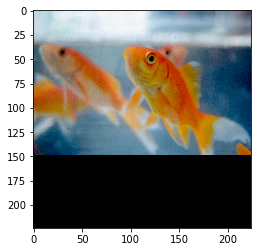

In [12]:
# Download the test image
if not os.path.exists("goldfish.jpg"):
    urllib.request.urlretrieve("https://images.unsplash.com/photo-1579161256825-57ba3094f057", "goldfish.jpg")

# Download the labels for Imagenet 1k
if not os.path.exists("imagenet1k.json"):
    urllib.request.urlretrieve("https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json", "imagenet1k.json")

# load the labels
labels = json.loads(open("imagenet1k.json", "r").read())

# load the image and pre-process it
x = preprocess(cv2.imread("goldfish.jpg"))

# run the model on inferentia and get the predictions
y = neuron_model(x).softmax(dim=1)

# list the top5 classes
top_5 = (-y[0]).argsort()[:5]
for l in top_5:
    print(f'Label: {labels[l]}, Confidence: {y[0][l]}')